# Paws and Pixels: My Dog's Routine Classification

## Introduction

**Can CNNs distinguish my dog from other dogs of the same breed? Can it identify if my dog is sitting, lying, standing, or being with people? And can it differentiate West Highland White Terriers (Westies) from Maltese dogs?**

The dataset used for this project is a collection of personal images from my Google Photos archive, specifically featuring my dog, Ronnie. Google Photos provides advanced image recognition capabilities, allowing it to differentiate between people, pets, and other objects. The images were retrieved from my Google Photos account. Using the [Google Takeout](https://takeout.google.com/) service, I exported the album titled "Ronnie", which contains all the photos of my dog, to a .zip file in my [Google Drive](https://drive.google.com/file/d/1VTN-mP8xqQBlyOhLwwj5kB9IgMEdIuBH/view?usp=sharing). This file was 1GB in size and included metadata and high-resolution images.

Initially, I attempted to expand the dataset by downloading additional photos from Google Photos. This required addressing duplicate images using Python, but my efforts to filter out duplicates were unsuccessful, as the code inadvertently retained them. The overwhelming task of cleaning the data led me to explore alternative datasets.

I discovered the  [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) through the  [Amesome Public Datasets](https://github.com/awesomedata/awesome-public-datasets) repository. This dataset included 170 images of West Highland White Terriers, the same breed as Ronnie. I incorporated these images into my final dataset to enrich its diversity and size. Additionally, after a passerby mistook Ronnie for a Maltese and said, "Take away your Maltese" (after that person's husky barked at Ronnie), I decided to evaluate whether my model could differentiate between West Highland White Terriers and similarly white-coated breeds like Maltese, since some dog owners cannot. 

In this assignment, I aim to enhance my understanding of image classification models like convolutional neural networks in addressing a meaningful and personally relevant classification problem.

## Loading, and Processing the Data

I am using converted dataset from Assignment 2, which was updated with new pictures of Westies that are not Ronnie, and Maltese dogs.

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

Using TensorFlow’s <code>image_dataset_from_directory</code>, I automatically loaded images from the converted_dataset_path into Python. For convenience, I resized all images to 160*160 pixels and introduced the batch size of 32. Each time we iterate over the dataset, we receive one batch—this batch will contain 32 image-label pairs (unless the last batch is smaller due to the total number of images not being perfectly divisible by 32). 

In [36]:
# Path to the dataset
dataset_path = r"C:\Users\PC\Downloads\Data\Final"

# Load the dataset without splitting
full_dataset = image_dataset_from_directory(
    dataset_path,
    seed=123,
    image_size=(160, 160),
    batch_size=32
)

print("Data loaded successfully!")
print(f"Number of batches: {len(full_dataset)}")

Found 1032 files belonging to 6 classes.
Data loaded successfully!
Number of batches: 33


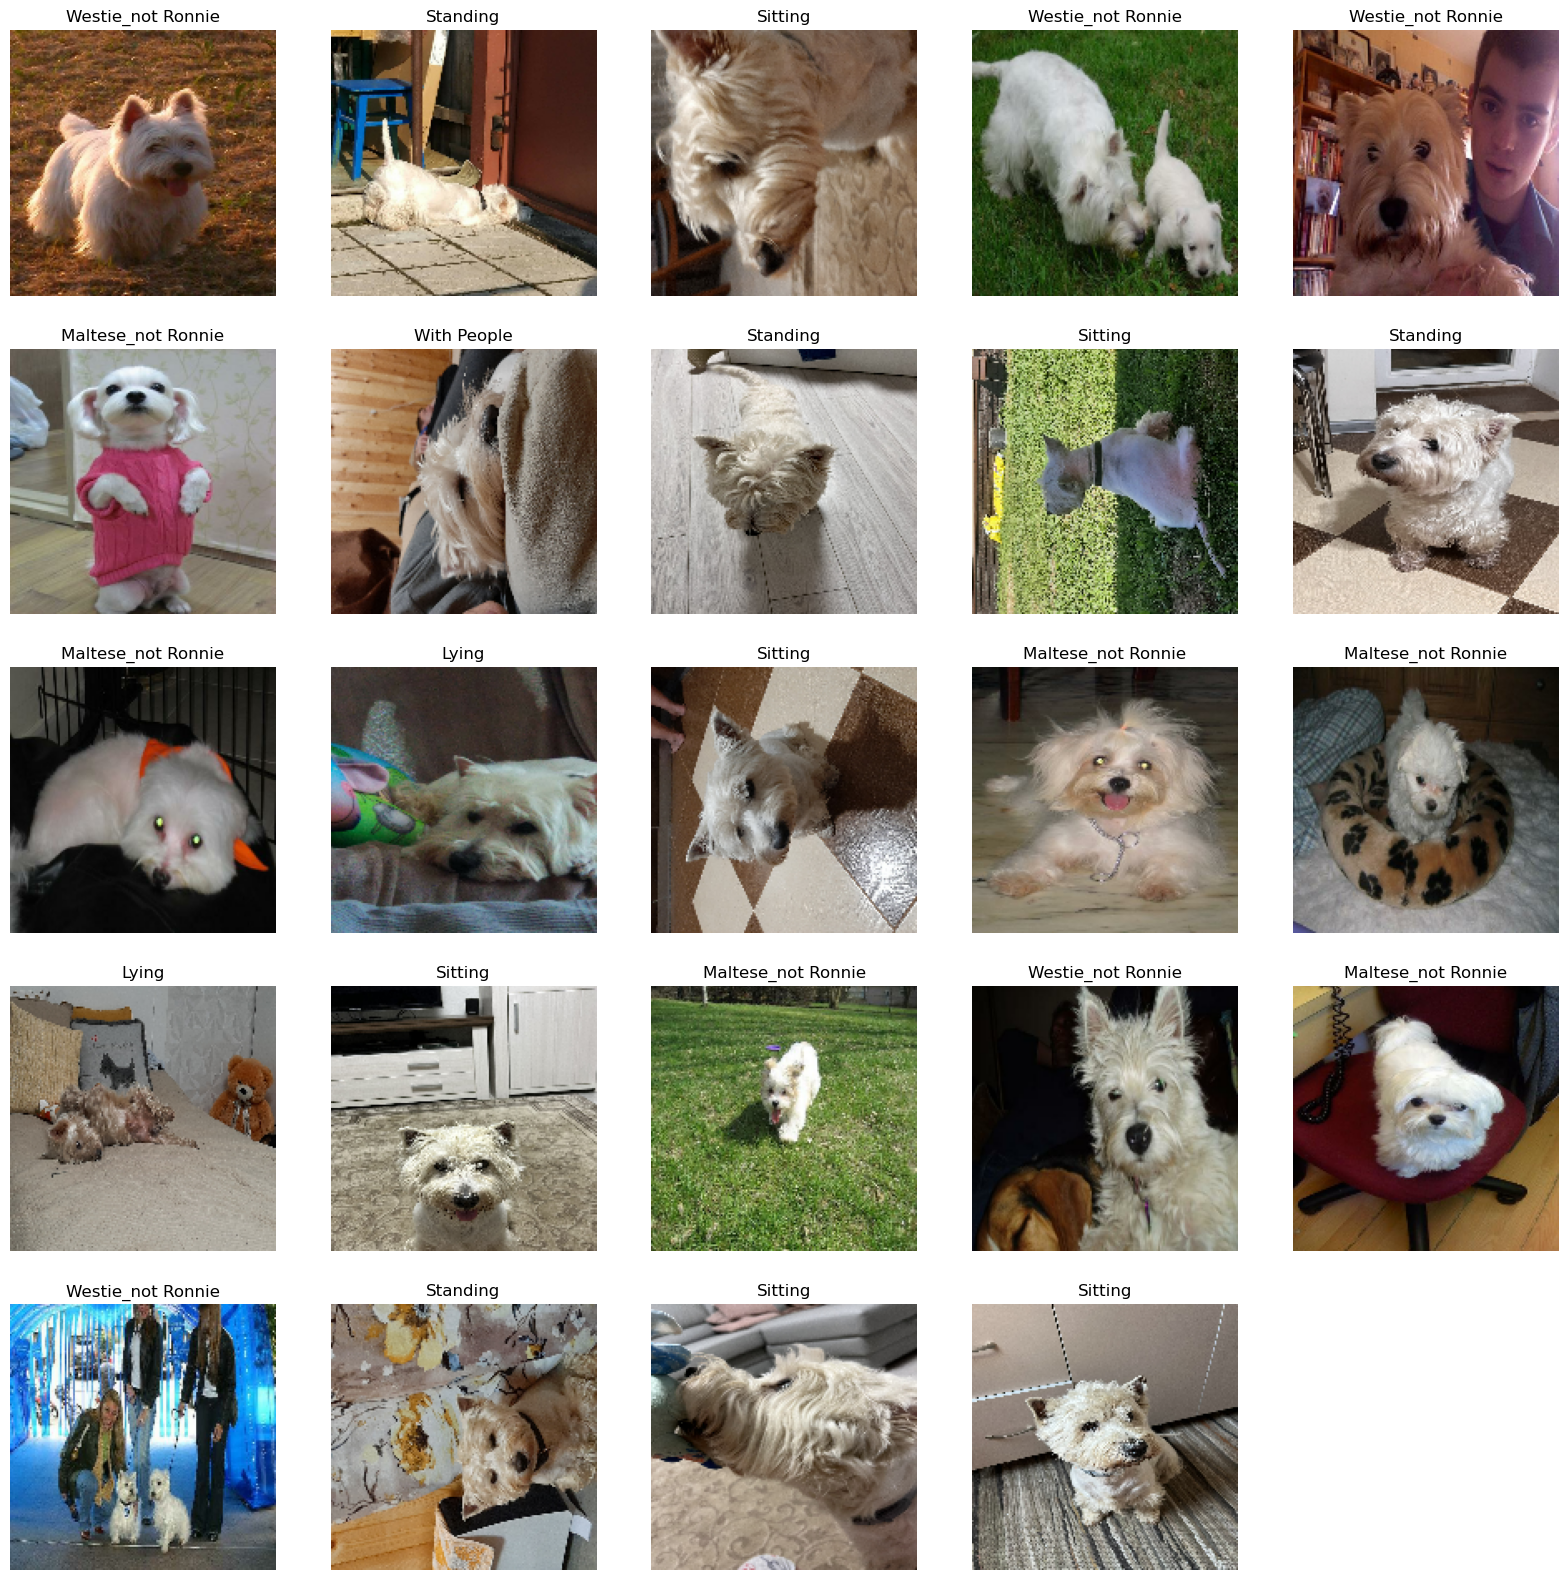

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
batch_count = 0

for images, labels in full_dataset.take(5):  # Take more batches
    for i in range(len(images)):
        ax = plt.subplot(5, 5, batch_count + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(full_dataset.class_names[labels[i]])
        plt.axis("off")
        batch_count += 1
        if batch_count >= 20:  # Stop after 20 images
            break
plt.show()

## Analysis
Here, I inspected the balance of my dataset using a function <code>count_files_in_classes</code>, which, given a directory (which presumably contains subdirectories for each class), counts how many image files are in each of these class subdirectories. 

The dataset consists of a total of 1,032 images, which is a significant increase compared to the 619 images used in the previous assignment. However, the dataset shows an imbalance across the classes:
- Ronnie With People: 81 images
- Ronnie Lying Down: 229 images
- Maltese Dogs: 252 images

This imbalance could affect the model's performance, particularly in underrepresented classes like "With People."

Class Counts:
Lying: 229
Maltese_not Ronnie: 252
Sitting: 178
Standing: 123
Westie_not Ronnie: 169
With People: 81


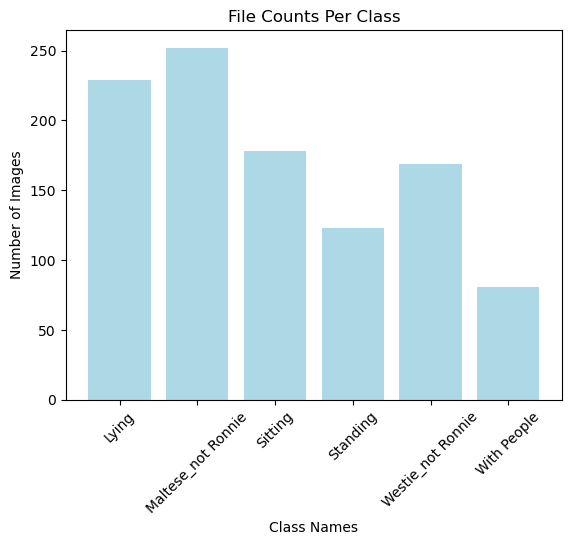

In [38]:
import os

def count_files_in_classes(directory):
    """
    Count the number of files in each subdirectory (class) of the given directory.
    """
    class_counts = {}
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):  # Only process directories
            file_count = len([f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))])
            class_counts[subdir] = file_count
    return class_counts

# Path to your dataset
dataset_path = r"C:\Users\PC\Downloads\Data\Final"

# Get the class counts
class_file_counts = count_files_in_classes(dataset_path)

# Display the dictionary with class names and file counts
print("Class Counts:")
for class_name, count in class_file_counts.items():
    print(f"{class_name}: {count}")

# Optional: Visualize the counts
import matplotlib.pyplot as plt

plt.bar(class_file_counts.keys(), class_file_counts.values(), color='lightblue')
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.title("File Counts Per Class")
plt.xticks(rotation=45)
plt.show()

## Model Selection: MobileNetV2

Our implementation uses transfer learning with a pre-trained MobileNetV2 convolutional neural network. This approach leverages features learned from ImageNet to accelerate training on our specific classification task.

1. Base Model (MobileNetV2):
   -  Pre-trained <MobileNetV2 (Sandler et al., 2018) with include the top `False`, meaning we remove the final classification layers and keep only the convolutional base.
   - The base model is frozen, `base_model.trainable = False`, so that the pre-trained weights do not get updated during training. This preserves the feature extraction capabilities already learned.

2. Input Layer:
   - We start with an Input layer that expects images of size 160x160 pixels with 3 color channels (RGB). A Rescaling layer normalizes pixel values from the original [0, 255] range to [0, 1]. This makes training more stable and efficient.

3. Feature Extraction:
   - After normalization, the images are passed into the MobileNetV2 base. MobileNetV2 uses depthwise separable convolutions and an efficient architecture to produce a rich set of feature maps. Since we are not training MobileNetV2 from scratch, we rely on its pre-learned filters to detect a variety of low-level to high-level features.
   
4. Global Average Pooling:
   - The feature maps from the base model are then passed through a GlobalAveragePooling2D layer. This operation averages the spatial dimensions of the feature maps, reducing them to a single feature vector. This step significantly reduces the number of parameters and helps avoid overfitting.

5. Regularization with Dropout:
   - To further prevent overfitting, a Dropout layer is applied. Dropout randomly sets a fraction (in this case, 20%) of input units to zero during training, encouraging the model to develop more robust features.

6. Final Classification Layer:
   - A final Dense layer with a softmax activation provides a probability distribution over the four classes. The softmax layer ensures that the output values sum to 1, representing the model’s confidence in each class.
  
We use <code>sparse_categorical_crossentropy</code> as the loss function. This is suitable when the labels are provided as integer values rather than one-hot encoded vectors.
The model is compiled with the adam optimizer. Adam adapts the learning rate during training for each parameter, making training more efficient and often faster to converge.

MobileNetV2 is a convolutional neural network (CNN) architecture that introduces two key innovators: inverted residuals and linear bottlenecks.

Traditional residual networks connect layers through shortcuts that bypass intermediate layers, aiding in gradient flow during training. MobileNetV2 inverts this approach by placing shortcut connections between thin bottleneck layers, with an expanded intermediate layer in between. 

In deep networks, nonlinear activation functions like ReLU introduce nonlinearity, enabling the model to learn complex patterns. However, applying ReLU to low-dimensional embeddings can cause information loss. To mitigate this, MobileNetV2 uses linear activation functions in the bottleneck layers, preserving essential information and enhancing representational capacity.

In traditional convolutions, computational $cost = height * width * input*output * kernel (k=3)$. 

Deepwise separable convolution, which this model uses, breaks into one kernel operating on each input channel, and pointwise convolution (combines the results from the previous convolution. $cost$ = $height * width * input* (kernel^2 + output)$

In [42]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Define the model architecture
inputs = layers.Input(shape=(160, 160, 3))
x = layers.Rescaling(1./255)(inputs)  # Normalize pixel values to [0, 1]
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # Regularization
outputs = layers.Dense(6, activation='softmax')(x)  # 4 classes

model = models.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 6)                 7686

## Model Selection: InceptionV3

After testing NasNet, ResNet, and EfficientNet, the validation accuracy consistently failed to exceed 30% for all three. Consequently, I selected **InceptionV3** for its architecture and suitability to my dataset’s characteristics:

- small dataset (1000) images
- class imbalance (InceptionV3 is strong when it comes to distinguishing between subtle activities)

InceptionV3 replaces large convolutions (5x5) with two smaller ones (3x3), reducing the computational cost. For instance, a single 5x5 convolution requires 25 multiplications per filter, while two 3x3 convolutions need only 18 multiplications.

$\text{Cost of 5*5 filter} = C^2 * 25$, $\text{Cost of 3*3 filter} = C^2 * 18$, where $C$ is the number of channels and $F$ is the filter size. 

High efficiency allows the model to perform well on small datasets.

The Inception module applies convolutions of varying sizes (1x1, 3x3, 5x5) in parallel, enabling it to capture features at multiple scales, making the model advantageous for tasks where objects or activities vary in size or subtlety. Mathematically, learning combination of feature maps is 

$\text{Feature Map} = \sum_{i \in \{1, 3, 5\}} W_i * X$, where $W_i$ are the learned weights for each convolution filter.


Here's a quick overview of other models I considered

- NasNet: uses Neural Architecture Search, effective on large dataset and has over 5.3 million parameters. I experimented with the model, and it showed NaN losses due to exploding gradients, a result of its depth and lack of robustness on small datasets.
- ResNet: uses residual blocks, where $X$ input is added to the output of a convolutional layer $F(X)$ ($H(X)=F(X) + X$). Helpful with mitigating vanishing gradients, but the depth of ResNet models (e.g., ResNet50 or ResNet101) often results in overfitting when used on small datasets like mine. Finally, it has 23.5 million parameters.
- EfficientNet: uses compound scaling with the width, depth and resolution, but itrequires careful fine-tuning of $𝜙$ and additional hyperparameters, making it less practical for smaller datasets with fewer iterations.

InceptionV3 provides strong generalization while still maintaining a balanced parameter count (21.8 million); its arcitechure is more mature for general purpose classification tasks. 

In [69]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models

# Load the pre-trained InceptionV3 model without the top layers
inception_base = InceptionV3(
    input_shape=(160, 160, 3),  # Custom input size for your dataset
    include_top=False,         # Exclude the dense layers at the top
    weights='imagenet'         # Pre-trained weights on ImageNet
)

# Freeze the convolutional base
inception_base.trainable = False

# Add a custom classification head
inputs = layers.Input(shape=(160, 160, 3))
x = layers.Rescaling(1./255)(inputs)  # Normalize pixel values to [0, 1]
x = inception_base(x, training=False)  # Use InceptionV3 as a feature extractor
x = layers.GlobalAveragePooling2D()(x)  # Reduce feature map dimensions
x = layers.Dropout(0.3)(x)  # Add dropout to prevent overfitting
outputs = layers.Dense(6, activation='softmax')(x)  # 6 output classes

# Create the final model
inception_model = models.Model(inputs, outputs)

# Compile the model
inception_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

inception_model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 rescaling_16 (Rescaling)    (None, 160, 160, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d_13  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_13 (Dropout)        (None, 2048)              0         
                                                                 
 dense_14 (Dense)            (None, 6)                 12294     
                                                          

## Data Splitting

Let's perform the data split: 20% for validation and 80% for training.

In [40]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

# Single directory containing all images (with subfolders for each class)
dataset_dir = r"C:\Users\PC\Downloads\Data\Final"

# Create the training dataset
train_dataset = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,   # Split off 20% for validation
    subset='training',      # Subset is 'training'
    seed=123,               # Seed for reproducibility
    label_mode='int',       # or "categorical"
    batch_size=32,
    image_size=(160, 160),
    shuffle=True
)

# Create the validation dataset
validation_dataset = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,   # Same fraction for validation
    subset='validation',    # Subset is 'validation'
    seed=123,
    label_mode='int',
    batch_size=32,
    image_size=(160, 160),
    shuffle=True
)

# Check the class names inferred
print("Class Names:", train_dataset.class_names)

print("Training and Validation datasets created successfully!")

Found 1032 files belonging to 6 classes.
Using 826 files for training.
Found 1032 files belonging to 6 classes.
Using 206 files for validation.
Class Names: ['Lying', 'Maltese_not Ronnie', 'Sitting', 'Standing', 'Westie_not Ronnie', 'With People']
Training and Validation datasets created successfully!


## Model Training: MobileNetV2

Using session 18 material on model checkpoints and early stopping, I trained ModelNetV2 on my dataset. 

EarlyStopping:
- This monitors a chosen metric (validation accuracy) and stops training early if the metric doesn't improve for five epochs (<code>patience=5</code>).
- The parameter <code>restore_best_weights=True</code> ensures that once training stops, the model weights are rolled back to the best-recorded epoch, not just the final epoch before stopping.

ModelCheckpoint:
- This callback saves the model's weights at the end of each epoch if there's an improvement. <code>save_best_only=True</code> ensures that only the best version of the model (e.g., the one with the lowest validation loss) is saved to <code>best_model.h5</code>. This way, you always have a saved model from the point of peak performance during training.

As we progress from Epoch 1 to Epoch 20, the training loss decreases from about 1.61 to 0.22, and training accuracy increases from about 39% to 94%. This indicates the model is learning and fitting the training data better over time. Validation accuracy improves from about 61% to about 84%.

In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',      # Monitors validation accuracy
    patience=5,                  # Stops if no improvement for 5 epochs
    restore_best_weights=True    # Restores weights from the best epoch
)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',    # Filepath to save the best model
    monitor='val_accuracy',      # Monitors validation accuracy
    mode='max',                  # Looks for maximum validation accuracy
    save_best_only=True,         # Saves only the best model
    verbose=1                    # Prints a message when saving the model
)

# Combine the callbacks
callbacks = [early_stopping, model_checkpoint]

# Train the model
history = model.fit(
    train_dataset,                # Training dataset
    validation_data=validation_dataset,  # Validation dataset
    epochs=20,                    # Total epochs to train
    callbacks=callbacks           # Pass the callbacks
)

# Save the final model to a file
model.save('final_model.h5')

Epoch 1/20
26/26 [==============================] - ETA: 0s - loss: 1.6148 - accuracy: 0.3923
Epoch 1: val_accuracy improved from -inf to 0.61650, saving model to best_model.h5
26/26 [==============================] - 33s 867ms/step - loss: 1.6148 - accuracy: 0.3923 - val_loss: 1.0542 - val_accuracy: 0.6165
Epoch 2/20
26/26 [==============================] - ETA: 0s - loss: 0.9990 - accuracy: 0.6320
Epoch 2: val_accuracy improved from 0.61650 to 0.68932, saving model to best_model.h5
26/26 [==============================] - 21s 696ms/step - loss: 0.9990 - accuracy: 0.6320 - val_loss: 0.8272 - val_accuracy: 0.6893
Epoch 3/20
26/26 [==============================] - ETA: 0s - loss: 0.8103 - accuracy: 0.6998
Epoch 3: val_accuracy improved from 0.68932 to 0.71845, saving model to best_model.h5
26/26 [==============================] - 21s 691ms/step - loss: 0.8103 - accuracy: 0.6998 - val_loss: 0.7600 - val_accuracy: 0.7184
Epoch 4/20
26/26 [==============================] - ETA: 0s - loss:

## Model Training: InceptionV3

Reusing callbacks from previous code cell, let's train InceptionV3. I run it on 18 epochs because when I checked it on 20, the validation accuracy and loss decreased, likely due to to high learning rate.

In [70]:
# Train the model
history = inception_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=18,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
inception_model.save('inceptionv3_final_model.h5')

Epoch 1/18
26/26 [==============================] - ETA: 0s - loss: 2.1873 - accuracy: 0.3886
Epoch 1: val_accuracy did not improve from 0.85922
26/26 [==============================] - 67s 2s/step - loss: 2.1873 - accuracy: 0.3886 - val_loss: 1.1870 - val_accuracy: 0.6505
Epoch 2/18
26/26 [==============================] - ETA: 0s - loss: 1.5229 - accuracy: 0.5460
Epoch 2: val_accuracy did not improve from 0.85922
26/26 [==============================] - 50s 2s/step - loss: 1.5229 - accuracy: 0.5460 - val_loss: 1.0136 - val_accuracy: 0.6845
Epoch 3/18
26/26 [==============================] - ETA: 0s - loss: 1.2638 - accuracy: 0.6162
Epoch 3: val_accuracy did not improve from 0.85922
26/26 [==============================] - 51s 2s/step - loss: 1.2638 - accuracy: 0.6162 - val_loss: 1.0578 - val_accuracy: 0.6845
Epoch 4/18
26/26 [==============================] - ETA: 0s - loss: 1.1006 - accuracy: 0.6453
Epoch 4: val_accuracy did not improve from 0.85922
26/26 [==========================

# Results

**MobileNetV2** has validation loss of 0.55, and accuracy of 84%

In [44]:
val_loss, val_accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

7/7 [==============================] - 5s 345ms/step - loss: 0.5470 - accuracy: 0.8398
Validation Loss: 0.5470
Validation Accuracy: 0.8398


1/1 [==============================] - 0s 397ms/step


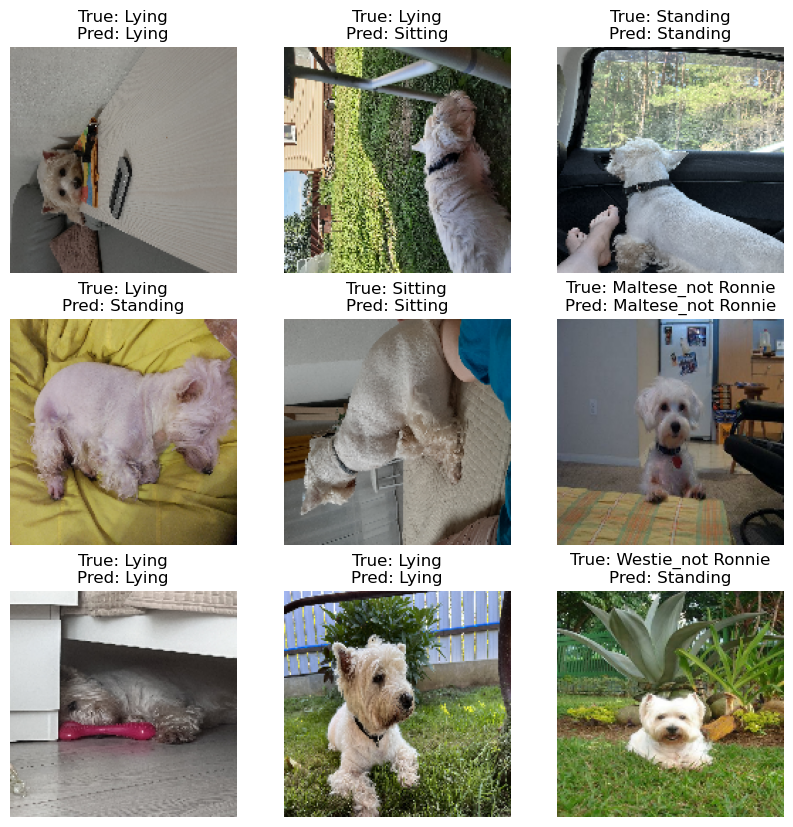

In [46]:
import matplotlib.pyplot as plt

# Get class names
class_names = validation_dataset.class_names

# Predict and visualize results
plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):  # Take one batch
    predictions = model.predict(images)
    predicted_classes = predictions.argmax(axis=1)
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        predicted_label = class_names[predicted_classes[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis("off")
plt.show()

**InceptionV3** has validation loss of 0.9, and accuracy of 72%

In [71]:
val_loss, val_accuracy = inception_model.evaluate(validation_dataset)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

7/7 [==============================] - 11s 1s/step - loss: 0.8978 - accuracy: 0.7184
Validation Loss: 0.8978
Validation Accuracy: 0.7184


1/1 [==============================] - 5s 5s/step


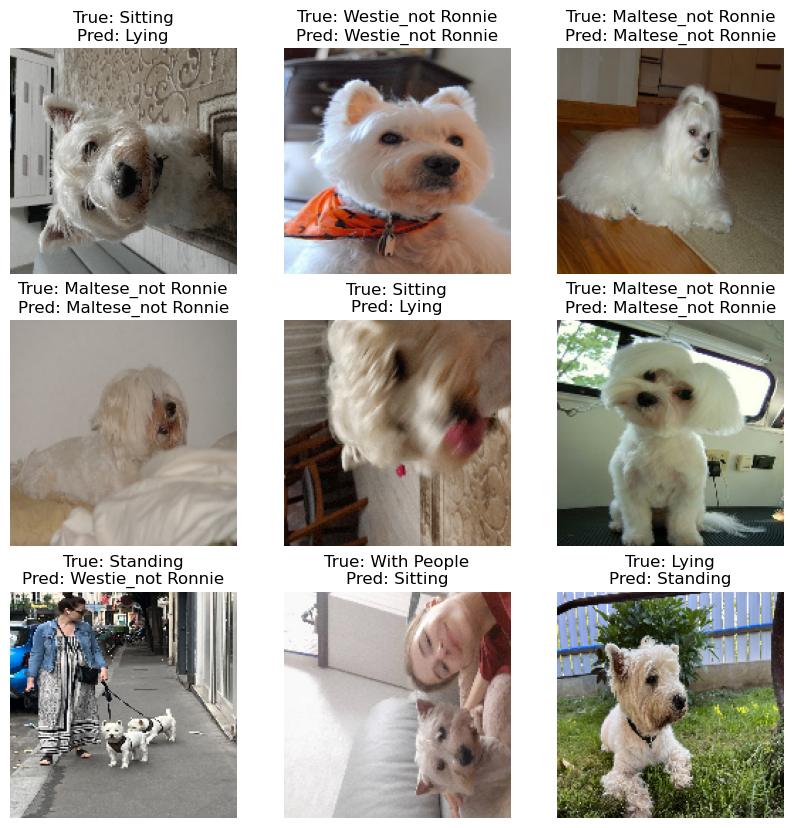

In [73]:
import matplotlib.pyplot as plt

# Get class names
class_names = validation_dataset.class_names

# Predict and visualize results
plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):  # Take one batch
    predictions = inception_model.predict(images)
    predicted_classes = predictions.argmax(axis=1)
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        predicted_label = class_names[predicted_classes[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis("off")
plt.show()

## Confusion Matrix: MobileNetV2

The confusion matrix visualizes correct predictions (diagonal elements) and misclassifications (off-diagonal elements). Each row represents the true labels, and each column represents the predicted labels. For example, the model correctly predicted "Lying" 40 times, while misclassifying it as "Sitting" 5 times. The <code>seaborn.heatmap()</code> function was used to plot the matrix, making it easier to identify which classes are frequently confused.

**The classification report:**

1. Lying
- Correct Predictions: 40/49 (precision = 0.83).
- Misclassifications: "Sitting": 5, "Standing": 1, "With People": 2, "Westie_not Ronnie": 1
- The model correctly predicts "Lying" 83% of the time, but there is some confusion with visually similar activities like "Sitting."
2. Maltese_not Ronnie
- Best-performing class with precision = 0.98 and recall = 0.93. 
- Correct Predictions: 51/55; misclassifications: Only 4.
- The model performs much better than rude humans in distinguishing Maltese from Westies, showcasing excellent generalization for this class.
3. With People
- This is the smallest class, with only 11 samples.
- Precision: 0.64, indicating more false positives.
- Recall: 0.82, meaning the model identifies "With People" well when it is present but struggles with overlap between "With People" and other classes (e.g., "Westie_not Ronnie" or "Maltese_not Ronnie").
4. Sitting
- Precision: 0.81 – Reasonably good
- Recall: 0.74 – The model misses 26% of "Sitting" instances, likely confusing them with "Lying" or "Standing."
5. Standing
- Precision: 0.80 – Good
- Recall: 0.67 – Struggles, likely due to similarities with other activity-based classes like "Sitting."
6. Westie_not Ronnie
- Precision: 0.78, Recall: 0.92.
- High recall means the model captures the majority of other Westies correctly.
- This strong recall may be a result of model bias, but its F1-score (0.84) and precision indicate overall solid performance.

Remaining challenges are class imbalance and my dog's activity overlaps. 

1/1 [==============================] - 2s 2s/step


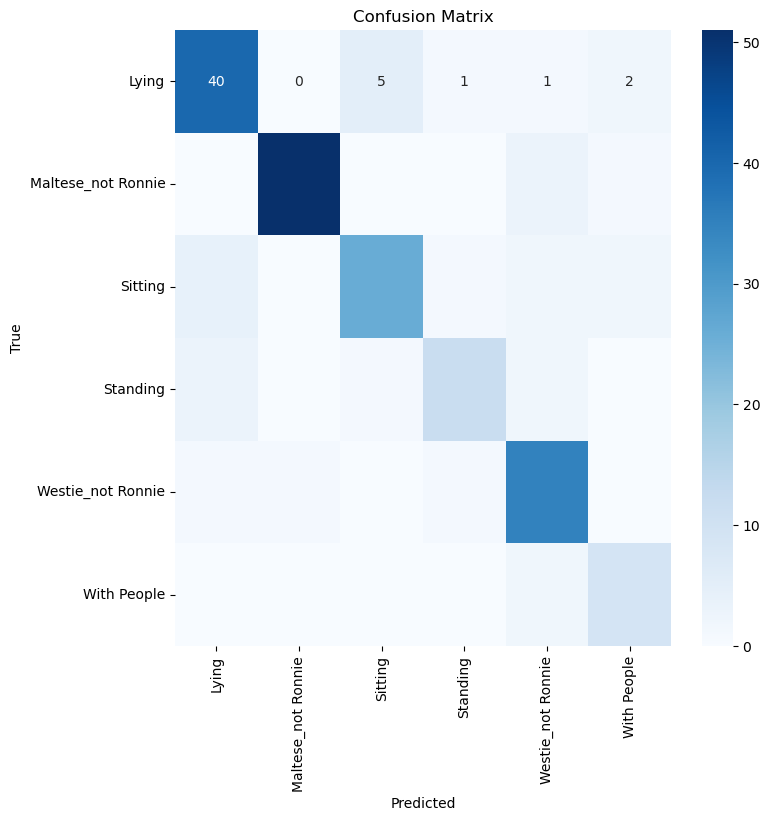

                    precision    recall  f1-score   support

             Lying       0.83      0.82      0.82        49
Maltese_not Ronnie       0.98      0.93      0.95        55
           Sitting       0.81      0.74      0.78        35
          Standing       0.80      0.67      0.73        18
 Westie_not Ronnie       0.78      0.92      0.84        38
       With People       0.64      0.82      0.72        11

          accuracy                           0.84       206
         macro avg       0.81      0.82      0.81       206
      weighted avg       0.85      0.84      0.84       206



In [47]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions
y_true = []
y_pred = []
for images, labels in validation_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions.argmax(axis=1))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

## Confusion Matrix: InceptionV3

1. Lying
- Correct Predictions: 36/49.
- Precision: 0.60 – Moderately good.
- Recall: 0.73 – The model identifies 73% of all "Lying" instances correctly but struggles to separate it from similar activities, particularly "Sitting" and "Standing."
- Misclassifications: "Sitting": 5 times; "Standing" or "With People": A few cases.
2. Maltese_not Ronnie
- Best-Performing Class: Precision: 0.95, Recall: 0.96 – Excellent performance.
- Correct Predictions: 53/55.
- Misclassifications are minimal, showing the model generalizes very well for this class, likely due to its distinct features. Models are once again better than people.
3. Sitting
- Precision: 0.58 – Moderate but leaves room for improvement.
- Recall: 0.43 – The model struggles with false negatives, correctly identifying only 43% of "Sitting" instances.
- Misclassifications with "Lying" and "Standing" are frequent due to visual similarities in these activities.
4. Standing
- Precision: 0.71 – Decent precision indicates that when the model predicts "Standing," it is usually correct.
- Recall: 0.28 – A major struggle; it misses 72% of "Standing" instances, often confusing them with other classes, particularly "Sitting."
5. Westie_not Ronnie
- Precision: 0.70, Recall: 0.92 – High recall indicates the model captures most -"Westie_not Ronnie" instances but sacrifices precision.
- Misclassifications suggest that subtle differences between "Westie" and "Maltese" are still challenging for the model.
6. With People
- Precision: 0.57 – The model has a high number of false positives.
- Recall: 0.36 – Low recall reflects difficulty in recognizing this class, likely due to the small sample size and overlap with other classes.

1/1 [==============================] - 4s 4s/step


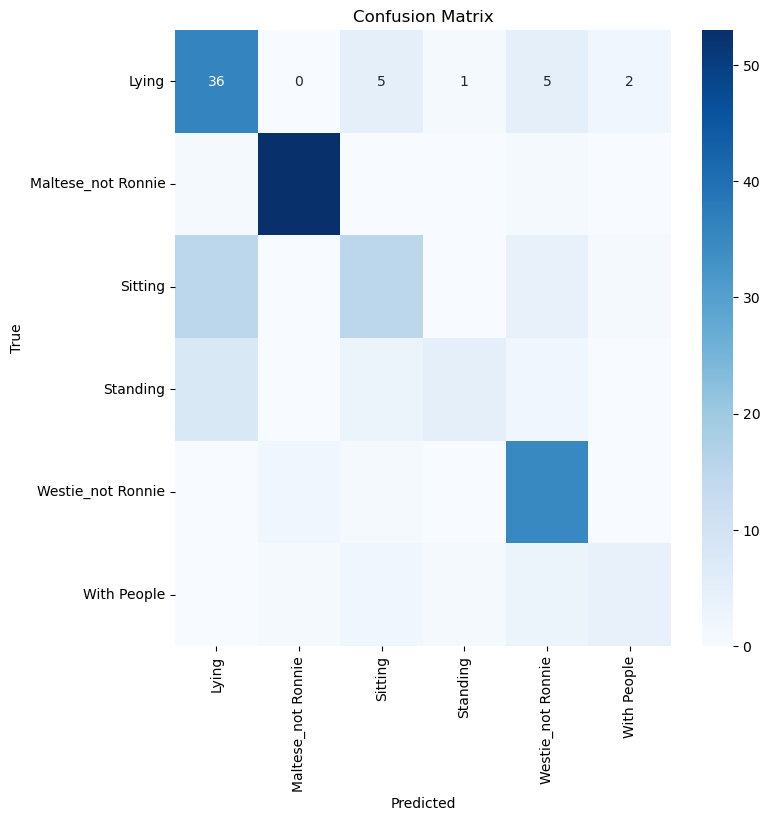

                    precision    recall  f1-score   support

             Lying       0.60      0.73      0.66        49
Maltese_not Ronnie       0.95      0.96      0.95        55
           Sitting       0.58      0.43      0.49        35
          Standing       0.71      0.28      0.40        18
 Westie_not Ronnie       0.70      0.92      0.80        38
       With People       0.57      0.36      0.44        11

          accuracy                           0.72       206
         macro avg       0.68      0.61      0.62       206
      weighted avg       0.72      0.72      0.70       206



In [74]:
# Generate predictions
y_true = []
y_pred = []
for images, labels in validation_dataset:
    predictions = inception_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions.argmax(axis=1))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

The bar chart below compares the per-class precision of **MobileNetV2** and **InceptionV3** models. MobileNetV2 consistently outperforms InceptionV3 in most classes, achieving higher precision across "Lying," "Sitting," "Standing," and "Westie_not Ronnie." Notably, both models excel in classifying "Maltese_not Ronnie," with MobileNetV2 achieving nearly perfect precision. 

However, InceptionV3 struggles significantly in classes like "Sitting," "Standing," and "With People," which likely stems from overlapping features and class imbalance. With an overall validation accuracy of **72% for InceptionV3** and **84% for MobileNetV2**, MobileNetV2 proves to be the superior model for this dataset, particularly in capturing subtle distinctions in activity-based classes.

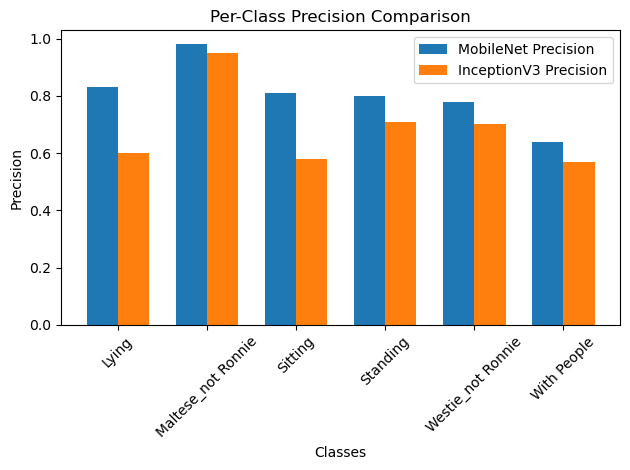

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for metrics (replace with actual values)
classes = ['Lying', 'Maltese_not Ronnie', 'Sitting', 'Standing', 'Westie_not Ronnie', 'With People']
precision_mobilenet = [0.83, 0.98, 0.81, 0.80, 0.78, 0.64]  # MobileNet values
precision_inception = [0.60, 0.95, 0.58, 0.71, 0.70, 0.57]  # InceptionV3 values

# Create bar chart
x = np.arange(len(classes))
width = 0.35

plt.bar(x - width/2, precision_mobilenet, width, label='MobileNet Precision')
plt.bar(x + width/2, precision_inception, width, label='InceptionV3 Precision')

plt.xlabel('Classes')
plt.ylabel('Precision')
plt.title('Per-Class Precision Comparison')
plt.xticks(x, classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Fine-tuning: MobileNetV2
- Optimizer: Adam with a low learning rate (1e-5) to prevent drastic changes.
- Loss: <code>sparse_categorical_crossentropy</code> for multiclass classification.
- Training: Performed 10 epochs with validation accuracy improving slightly (from ~84% to ~86%).
- Final validation loss = 0.4888.
- Final validation accuracy = 85.92%.

In [48]:
# Unfreeze the base model
base_model.trainable = True

# Compile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
fine_tune_history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,  # Add a few epochs for fine-tuning
    callbacks=callbacks
)

# Evaluate the fine-tuned model
fine_val_loss, fine_val_accuracy = model.evaluate(validation_dataset)
print(f"Fine-Tuned Validation Loss: {fine_val_loss:.4f}")
print(f"Fine-Tuned Validation Accuracy: {fine_val_accuracy:.4f}")

Epoch 1/10
26/26 [==============================] - ETA: 0s - loss: 0.1932 - accuracy: 0.9516
Epoch 1: val_accuracy improved from 0.83981 to 0.84951, saving model to best_model.h5
26/26 [==============================] - 87s 2s/step - loss: 0.1932 - accuracy: 0.9516 - val_loss: 0.5149 - val_accuracy: 0.8495
Epoch 2/10
26/26 [==============================] - ETA: 0s - loss: 0.1309 - accuracy: 0.9746
Epoch 2: val_accuracy did not improve from 0.84951
26/26 [==============================] - 50s 2s/step - loss: 0.1309 - accuracy: 0.9746 - val_loss: 0.5069 - val_accuracy: 0.8398
Epoch 3/10
26/26 [==============================] - ETA: 0s - loss: 0.1045 - accuracy: 0.9770
Epoch 3: val_accuracy improved from 0.84951 to 0.85437, saving model to best_model.h5
26/26 [==============================] - 50s 2s/step - loss: 0.1045 - accuracy: 0.9770 - val_loss: 0.4922 - val_accuracy: 0.8544
Epoch 4/10
26/26 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9843
Epoch 4: val_a

### Fine-tuning: InceptionV3

- 10 epochs used
- uunfreezing all base layers and freezing earlier layers for lower-level features (edges, shapes) to remain unchanged.
- slowing down the learning rate to 1e-5
- validation accuracy from 72% to 76%, and validation loss from 0.9 to 0.81

In [76]:
# Unfreeze the top layers of the InceptionV3 base model
inception_base.trainable = True  # Unfreeze the entire base model

# freeze earlier layers to focus fine-tuning on deeper layers
for layer in inception_base.layers[:-50]:  # Freeze all layers except the last 50
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
inception_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_finetune = inception_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the fine-tuned model
inception_model.save('inception_finetuned_model.h5')

Epoch 1/10
26/26 [==============================] - ETA: 0s - loss: 0.5516 - accuracy: 0.7942
Epoch 1: val_accuracy did not improve from 0.85922
26/26 [==============================] - 84s 2s/step - loss: 0.5516 - accuracy: 0.7942 - val_loss: 0.8054 - val_accuracy: 0.7427
Epoch 2/10
26/26 [==============================] - ETA: 0s - loss: 0.3910 - accuracy: 0.8680
Epoch 2: val_accuracy did not improve from 0.85922
26/26 [==============================] - 59s 2s/step - loss: 0.3910 - accuracy: 0.8680 - val_loss: 0.8047 - val_accuracy: 0.7379
Epoch 3/10
26/26 [==============================] - ETA: 0s - loss: 0.3721 - accuracy: 0.8632
Epoch 3: val_accuracy did not improve from 0.85922
26/26 [==============================] - 58s 2s/step - loss: 0.3721 - accuracy: 0.8632 - val_loss: 0.7765 - val_accuracy: 0.7524
Epoch 4/10
26/26 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.9165
Epoch 4: val_accuracy did not improve from 0.85922
26/26 [==========================

## Conclusion

In this assignment, I implemented and evaluated two models, **MobileNetV2** and **InceptionV3**, to classify the activities of my dog, differentiate my dog from other Westies, and distinguish Westies from Maltese dogs. Through the analysis, it was evident that both models had strengths and weaknesses depending on the class. The easiest classification task was the "Maltese_not Ronnie" class, where both models achieved high precision and recall due to the distinct visual characteristics of Maltese dogs compared to Westies.

However, both models struggled the most with activity-based classes, particularly "Standing" and "Sitting," likely due to visual similarities between these postures. **InceptionV3** further struggled with the "With People" class, which can be attributed to the small number of samples and overlap with other classes (e.g., "Westie_not Ronnie"). This highlights the challenges posed by class imbalance and the model’s difficulty in capturing the subtle distinctions when my dog is pictured alongside people.

Overall, **MobileNetV2** emerged as the superior model for this dataset, consistently achieving higher validation accuracy and better precision, recall, and F1-scores across most classes. Its lightweight architecture and efficient use of parameters allowed it to generalize better to this relatively small dataset. While InceptionV3 offers strong theoretical advantages with its multi-scale feature extraction, MobileNetV2 proved to be the more practical choice for this specific task, providing faster training and better overall performance. Future improvements could involve addressing class imbalance and expanding the dataset for challenging classes like "With People" and "Standing."

# References + AI Statement
[Unleashing MobileNetV2: Efficient CNN Insights](https://www.linkedin.com/pulse/unleashing-mobilenetv2-efficient-cnn-insights/)

This article discusses the mathematical and conceptual aspects of MobileNetV2, including depthwise separable convolutions, inverted residuals, and linear bottlenecks.

[Transfer Learning with TensorFlow](tensorflow.org/tutorials/images/transfer_learning#data_download)

This tutorial demonstrates how to use pre-trained models like MobileNetV2 for transfer learning, including data preprocessing, training, and evaluation processes.

[Stanford Dogs](http://vision.stanford.edu/aditya86/ImageNetDogs/)

I used this dataset to download the pictures of dogs. Developed by Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao and Li Fei-Fei.

[NasNet Tutorial]([https://keras.io/api/applications/nasnet/])

The NasNet tutorial provides an overview of how to use pre-trained NasNet models, such as NasNetMobile and NasNetLarge, for transfer learning or feature extraction in custom tasks. It explains how to load these models with or without the top layers, configure input shapes, and fine-tune them for specific datasets.

[Inception V3, Papers With Code](https://paperswithcode.com/method/inception-v3#:~:text=**Inception%2Dv3**%20is,propagate%20label%20information%20lower%20down)

Inception-v3 is a convolutional neural network architecture that improves upon its predecessors by factorizing convolutions. The model, which achieves a top-5 error of 3.46% on the ImageNet challenge, introduces several architectural modifications including factorizing 7x7 convolutions into smaller 3x3 convolutions.

I used AI tools for grammar checking, and brainstorming ideas for the assignment. I also used it for code checks, although I could adapt most of the code from class and transfer the learning notebook for PCW. I used ChatGPT to restructure my responses to make them more readable. I also used AI to explain to me new models that I was implementing in this assignment. 